# DeepRacer Sim2Real Evaluations

This notebook is for running varying levels of evaluation on simulation-trained models
targeting physical DeepRacer hardware and real-world conditions.

The evaluation conditions are greatly inspired by https://arxiv.org/pdf/1911.01562.pdf and aim to provide similar results and confidence going from simulation to physical racing.

The evaluations here aim to:

    A. Provide a evaluation suite which can predict sim2real success as best as possible
    B. Save time in loading models to physical hardware in order to evaluate training variables
    C. Verify custom tuning of DeepRacer training, such as image perturbations and network dropout
    
## Actionable exerpts from the paper

### General
- The model that perform consistently well with robust evaluation also perform well on the real track
- The models are particularly robust when a sequence of checkpoints perform well in simulator. 
- Track A = reinvent 2018
- Track B = China training
- Track C = Tokyo training
- Track D = ?

### Training guidance

- Reversing the direction of travel significantly improves model performance.
- Action noise does not help by itself, but improves performance when combined with reverse. 
- Policies trained on Track B do not perform well for checkpoints in Figure 6, but with more training start performing well in both robust evaluation and real track, policy checkpoint 35 traversed the real track successfully 5 out of 6 trials.
- The performance of the model changes dramatically at slower speeds (35s lap, 0.5 m/s), even checkpoint 5 of the policy trained on Track A with no randomization traverses the real track. This model is trained in <5 minutes.
- All the above policies were trained in <1 hour with 4 rollouts.

- Training on a different track gives good sim2real results, but vary track to track.
- For regularization, we used L2 norm, dropout, batch normalization and an entropy bonus to the policy loss.
- We tested the models that give best performance in robust evaluation.
- Reducing the entropy bonus to 0.001 (it is 0.1 by default) and dropout with probability 0.3 were particularly effective.
- Larger throttle speeds in training increased the robustness of the model dramatically but also increased convergence time in the presence of action noise. 
- Mixing multiple tracks during training did not lead to improvement in performance. 
- We perturb the observation images with random color, horizontal translation, shadow, and salt and pepper noise, each with 0.2 probability.
- For random color, we combine the effects of random hue, saturation, brightness and contrast to create variations in observation. 
- Random color was the most effective method for sim2real transfer.
- We combine the best of our parameters and train a model on Track C with L2 regularlization, lower entropy bonus, dropout, color randomization and a maximum throttle of 2.33 m/s. This model performed the best overall in our experiments. The model consistently completed 11 second laps (1.6 m/s) in our Track A replica.

### Evaluation guidance

- For robust evaluation, we add uniform random noise to actions, evaluate in multiple starting positions and both directions of travel on Track A.
- For naive evaluation, we evaluate on Track A with a fixed starting point without randomization.
- Both evaluations test each checkpoint 10 times in simulator.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import json
from log_analysis import *
import cw_utils
import s3_fluent_logs
import s3_models
import seaborn as sns
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import skimage
import sys

In [3]:
# Find available Tensorflow pb models

s3_bucket='aws-deepracer-b6c3c104-eef5-4878-a257-d981cd204d62'

# 4-claudius no-mods: tokyo track
job_id='20191110045154-91e80226-86b5-41fc-8ea2-37bdc070dfcd'

s3_prefix='training-jobs/%s/shared/model' % job_id
log_path='models/%s' % job_id
print("Available checkpoints to load")
s3_models.list_available_checkpoints(s3_bucket, s3_prefix, log_path)


Available checkpoints to load


['model_0.pb',
 'model_1.pb',
 'model_10.pb',
 'model_11.pb',
 'model_12.pb',
 'model_13.pb',
 'model_14.pb',
 'model_15.pb',
 'model_16.pb',
 'model_17.pb',
 'model_18.pb',
 'model_19.pb',
 'model_2.pb',
 'model_20.pb',
 'model_21.pb',
 'model_22.pb',
 'model_23.pb',
 'model_24.pb',
 'model_25.pb',
 'model_26.pb',
 'model_27.pb',
 'model_28.pb',
 'model_29.pb',
 'model_3.pb',
 'model_30.pb',
 'model_31.pb',
 'model_32.pb',
 'model_33.pb',
 'model_34.pb',
 'model_35.pb',
 'model_36.pb',
 'model_37.pb',
 'model_38.pb',
 'model_39.pb',
 'model_4.pb',
 'model_40.pb',
 'model_41.pb',
 'model_42.pb',
 'model_43.pb',
 'model_44.pb',
 'model_45.pb',
 'model_46.pb',
 'model_47.pb',
 'model_48.pb',
 'model_49.pb',
 'model_5.pb',
 'model_50.pb',
 'model_51.pb',
 'model_52.pb',
 'model_53.pb',
 'model_54.pb',
 'model_55.pb',
 'model_56.pb',
 'model_57.pb',
 'model_58.pb',
 'model_59.pb',
 'model_6.pb',
 'model_60.pb',
 'model_7.pb',
 'model_8.pb',
 'model_9.pb']

In [108]:
def download_model(iteration):
    fname = 'model_%d.pb' % iteration
    model_path = s3_models.download_checkpoint(s3_bucket, s3_prefix, fname, log_path)
    return model_path

# Find the number of actions in the model's action space, needed for loading the network
actions_path = s3_models.download_actions(s3_bucket, s3_prefix, log_path)
with open(actions_path, "r") as f:
    action_space = json.load(f)
    
number_of_actions = len(action_space['action_space'])
number_of_actions, actions_path

(10,
 'models/20191110045154-91e80226-86b5-41fc-8ea2-37bdc070dfcd/model_metadata.json')

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

def load_session(pb_path):
    sess = tf.Session(s=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)

    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [6]:
# Inspect the model
#op = model.graph.get_operations()
#for m in op:
#    print(m.name)

In [7]:
# Show available image files
import glob
image_path = 'images'
image_files = sorted(glob.glob(image_path + '/*.png'))
#image_files

In [5]:
import cv2
import numpy as np
import tensorflow as tf

def analyze_image(image_path):
    img = Image.open(image_path)
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    current_state = {"observation": img_arr} #(1, 120, 160, 1)
    y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
    return y_output

def grey_image(image_path):
    image = Image.open(image_path)    
    grey_img = image.convert('L')
    return grey_img
    
def visualize_gradcam_discrete_ppo(sess, image_path, category_index=0, num_of_actions=6):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    image = Image.open(image_path)    
    rgb_img = np.array(image)
    img_arr = rgb2gray(rgb_img)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/observation/observation:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/observation/Conv2d_4/Conv2D:0')
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

# Optionally plot the probabilities as a seaborn 2d grid for speed-steer
def plot_action_probabilities(model_metadata, probabilities):
    # @model_metadata should be the parsed json of model_metadata.json
    # @probabilities should be a list of probabilities output from analyze_image
    df_actions = pd.DataFrame(model_metadata['action_space'])
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(211)
    sns.scatterplot(x='steering_angle',
                    y='speed', 
                    size=result,
                    sizes=(100,1000),
                    hue=result, 
                    data=df_actions,
                    ax=ax)
    ax.set_title('Action Probabilities')
    ax.set_xlim(df_actions['steering_angle'].max()+5,df_actions['steering_angle'].min()-5);
    ax = fig.add_subplot(212)
    plt.bar(range(number_of_actions), result)


In [111]:
# Load the model into tensorflow
try:
    model.close()
    tf.reset_default_graph()
except NameError as e:
    pass
model_path = download_model(60)
model, obs, model_out = load_session(model_path)

W1111 16:09:05.537391 4697568704 deprecation.py:323] From <ipython-input-5-5b2e5da9985f>:10: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


load graph: models/20191110045154-91e80226-86b5-41fc-8ea2-37bdc070dfcd/model_60.pb


In [107]:
# Specific to captures of Canada Training track
image_file = 'images/reinvent2018/2/4.png' # straight
result = analyze_image(image_file)
print("Straight: ", result)
plot_action_probabilities(action_space, result)
Image.open(image_file)

NameError: name 'model' is not defined

Straight:  [0.11656491 0.13442026 0.04458045 0.05024379 0.05212151 0.1283854
 0.14080158 0.26512063 0.04640539 0.0213561 ]


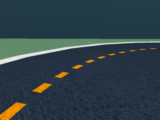

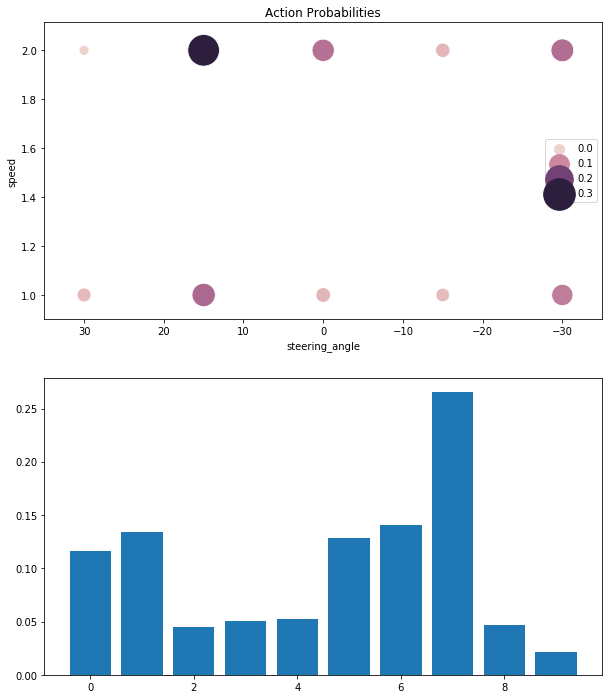

In [160]:
# Specific to captures of Canada Training track
image_file = 'images/reinvent2018/2/216.png' # straight
result = analyze_image(image_file)
print("Straight: ", result)
plot_action_probabilities(action_space, result)
Image.open(image_file)

Straight:  [0.20825419 0.12179239 0.16231158 0.06200922 0.09160814 0.05296043
 0.08937488 0.07804281 0.05829431 0.07535198]


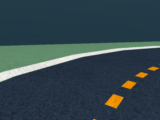

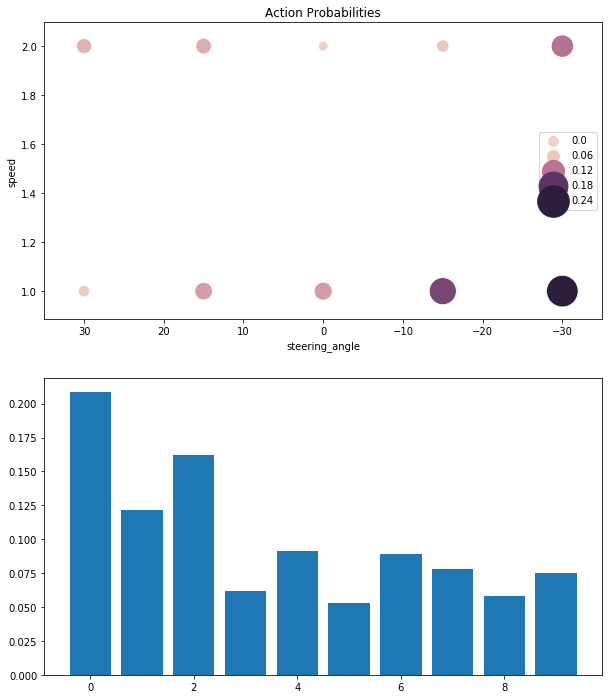

In [189]:
# Specific to captures of Canada Training track
image_file = 'images/reinvent2018/2/252.png' # straight
result = analyze_image(image_file)
print("Straight: ", result)
plot_action_probabilities(action_space, result)
Image.open(image_file)

# Run a suite of images

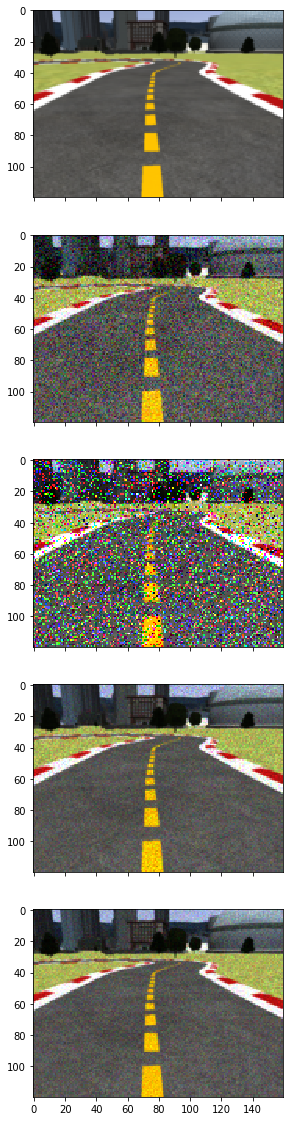

In [45]:
# Noise

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 20),
                       sharex=True, sharey=True)
image = Image.open(image_file)
ax[0].imshow(image)
gaussian = skimage.util.random_noise(np.array(image)) #, var=0.001)
ax[1].imshow(gaussian)
salt_pepper = skimage.util.random_noise(np.array(image), mode='s&p', amount=0.2)
ax[2].imshow(salt_pepper)
speckle = skimage.util.random_noise(np.array(image), mode='speckle')
ax[3].imshow(speckle)
poisson = skimage.util.random_noise(np.array(image), mode='poisson')
ax[4].imshow(poisson)

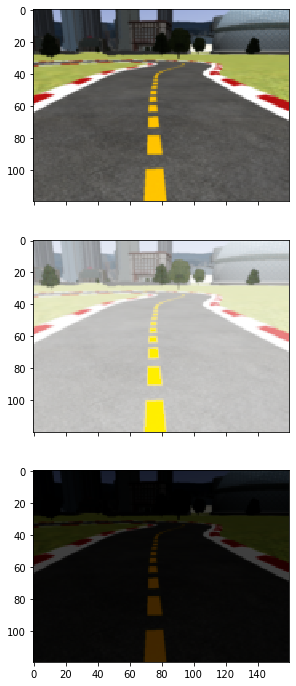

In [62]:
# Contrast & brightness
import skimage.exposure

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12),
                       sharex=True, sharey=True)
image = Image.open(image_file)
ax[0].imshow(image)
gamma_lo = skimage.exposure.adjust_gamma(np.array(image), 0.25)
ax[1].imshow(gamma_lo)
gamma_hi = skimage.exposure.adjust_gamma(np.array(image), 2, 0.25)
ax[2].imshow(gamma_hi)

W1109 17:51:50.238473 4503782848 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape:  (120, 160, 3)


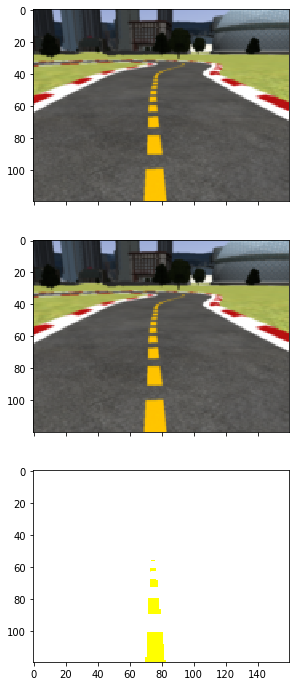

In [66]:
# Motion blur
# https://github.com/scikit-image/scikit-image/issues/2400
image1 = Image.open('images/canada_training/1680.png')
image2 = Image.open('images/canada_training/1681.png')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12),
                       sharex=True, sharey=True)
print("Shape: ", np.array(image1).shape)
alpha = 0.5
blurred = alpha * np.array(image1) + (1 - alpha) * np.array(image2)
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(blurred)

Text(0.5, 1.0, 'Cumulative')

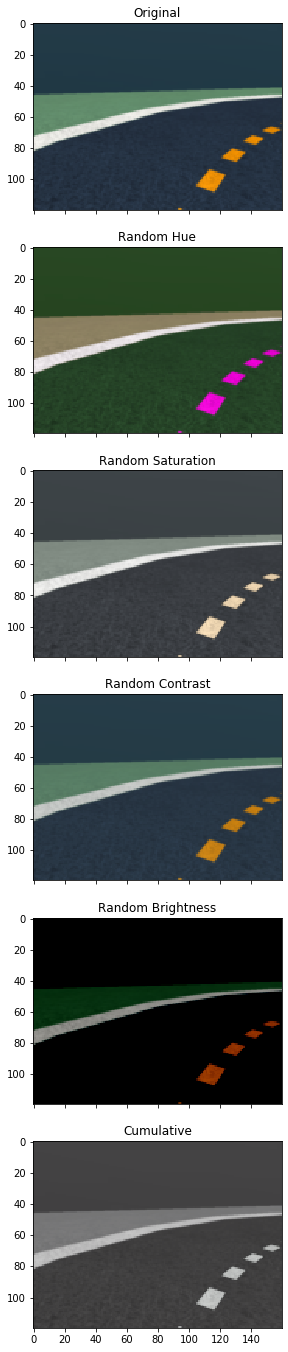

In [114]:
# Imag manipulation using Tensorflow

fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(12, 24),
                       sharex=True, sharey=True)
image = Image.open(image_file)
image_array = tf.convert_to_tensor(np.array(image))
ax[0].imshow(image_array.eval(session=model))
ax[0].set_title('Original')
#hue_image = tf.image.random_hue(image_array, 0.5)
hue_image = tf.image.adjust_hue(image_array, 0.75)
ax[1].imshow(hue_image.eval(session=model))
ax[1].set_title('Random Hue')
# saturation
sat_image = tf.image.random_saturation(image_array, 0.0, 1.0)
ax[2].imshow(sat_image.eval(session=model))
ax[2].set_title('Random Saturation')
# contrast
contrast_image = tf.image.random_contrast(image_array, 0.0, 1.0)
ax[3].imshow(contrast_image.eval(session=model))
ax[3].set_title('Random Contrast')
# brightness
bright_image = tf.image.random_brightness(image_array, 0.5)
ax[4].imshow(bright_image.eval(session=model))
ax[4].set_title('Random Brightness')

cumulative = tf.convert_to_tensor(np.array(image))
#print(cumulative.shape)
cumulative = tf.image.random_hue(cumulative, 0.5)
cumulative = tf.image.random_saturation(cumulative, 0.0, 1.0),
cumulative = tf.image.random_contrast(cumulative, 0.0, 1.0),                                                                              
cumulative = tf.image.random_brightness(cumulative, 0.5)
cum_eval = cumulative.eval(session=model)[0][0]
ax[5].imshow(cum_eval)
ax[5].set_title('Cumulative')


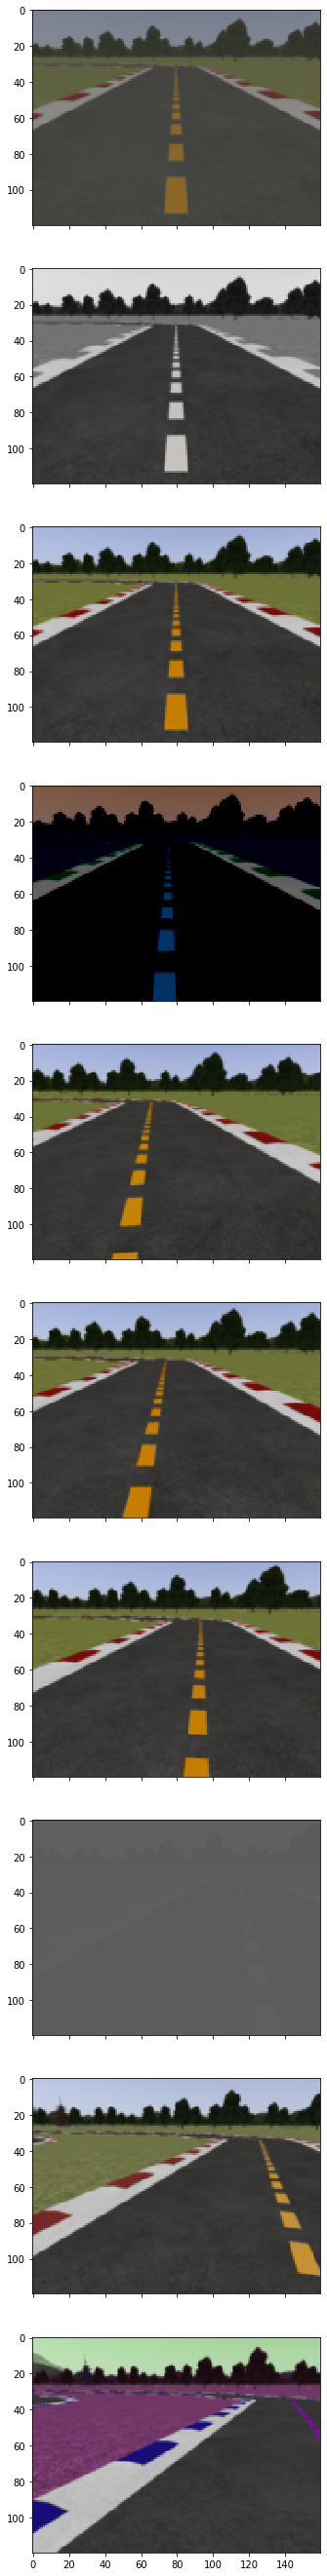

In [115]:
image1 = Image.open('images/perturb/color_perturb_filter_1573484554.615780.png')
image2 = Image.open('images/perturb/color_perturb_filter_1573484555.343044.png')
image3 = Image.open('images/perturb/color_perturb_filter_1573484555.640556.png')
image4 = Image.open('images/perturb/color_perturb_filter_1573484556.194312.png')
image5 = Image.open('images/perturb/color_perturb_filter_1573484556.490396.png')
image6 = Image.open('images/perturb/color_perturb_filter_1573484556.781048.png')
image7 = Image.open('images/perturb/color_perturb_filter_1573484556.989721.png')
image8 = Image.open('images/perturb/color_perturb_filter_1573484557.328982.png')
image9 = Image.open('images/perturb/color_perturb_filter_1573484557.582618.png')
image10 = Image.open('images/perturb/color_perturb_filter_1573484557.881694.png')
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(12, 48),
                       sharex=True, sharey=True)
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image3)
ax[3].imshow(image4)
ax[4].imshow(image5)
ax[5].imshow(image6)
ax[6].imshow(image7)
ax[7].imshow(image8)
ax[8].imshow(image9)
ax[9].imshow(image10)

Text(0.5, 1.0, 'Random Brightness 46')

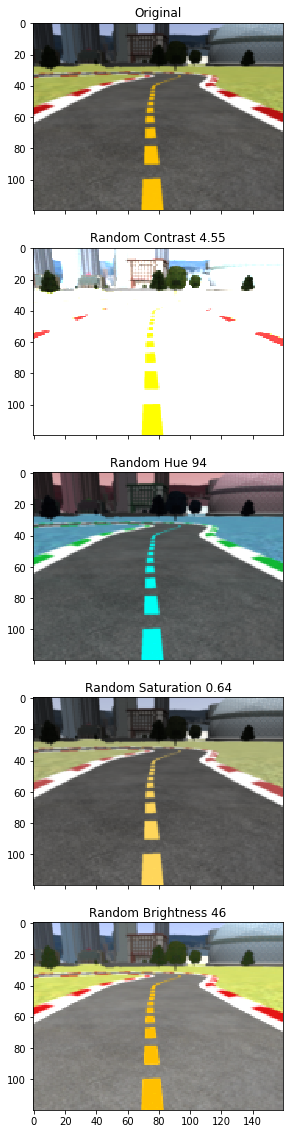

In [31]:
from PIL import ImageEnhance

image_file = 'images/canada_training/1680.png'

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 20),
                       sharex=True, sharey=True)
image = Image.open(image_file)
ax[0].imshow(image)
ax[0].set_title('Original')

# contrast: multiplier in RGB space
contrast_mult = np.random.exponential() #np.random.uniform(0.5,1.5)
new_contrast_array = np.array(image, 'float') * contrast_mult
new_contrast_array = np.clip(new_contrast_array, 0, 255)
contrast_image = Image.fromarray(new_contrast_array.astype('uint8'))

ax[1].imshow(contrast_image)
ax[1].set_title('Random Contrast %.2f' % contrast_mult)

# HSV conversion
hsv_image = image.convert(mode='HSV')
h,s,v = hsv_image.split()

# hue: rotation
# PIL uses 0..255 for Hue range
hue_delta = np.random.randint(0,255)
hue_array = np.array(h, dtype='float') # convert to flow to allow overflow
new_hue_array = (hue_array + hue_delta) % 256
new_h = Image.fromarray(new_hue_array.astype('uint8'), 'L')

hue_image = Image.merge('HSV', (new_h,s,v))
ax[2].imshow(hue_image)
ax[2].set_title('Random Hue %d' % hue_delta)

# saturation: multiplier
sat_mult = np.random.uniform(0.0,1.0)
sat_array = np.array(s, dtype='float')
new_sat_array = sat_array * sat_mult
new_sat_array = np.clip(new_sat_array, 0, 255)
new_s = Image.fromarray(new_sat_array.astype('uint8'), 'L')

sat_image = Image.merge('HSV', (h,new_s,v))
ax[3].imshow(sat_image)
ax[3].set_title('Random Saturation %.2f' % sat_mult)


# brightness: delta
#   a: PIL ImageEnhance
#bright_delta = np.random.random()
#bright_image = ImageEnhance.Brightness(image).enhance(bright_delta)
#ax[4].imshow(bright_image)
#   b: hs{v|b}
bright_delta = np.random.randint(-127,127)
#print("bright_delta ", bright_delta)
bright_array = np.array(v, dtype='float')
new_bright_array = bright_array + bright_delta
new_bright_array = np.clip(new_bright_array, 0, 255)
#if bright_delta > 0:
#    bright_array = np.where((255 - bright_array) < bright_delta, 255, bright_array + bright_delta)
#else:
#    bright_array = np.where(bright_array < -bright_delta, 0, bright_array + bright_delta)
new_v = Image.fromarray(new_bright_array.astype('uint8'), 'L')

bright_image = Image.merge('HSV', (h,s,new_v))
ax[4].imshow(bright_image)
ax[4].set_title('Random Brightness %d' % bright_delta)


Changes: Contrast,Hue,Saturation,Brightness
Changes: Contrast,Hue,Saturation,Brightness
Changes: Contrast,Hue,Saturation,Brightness
Changes: Contrast,Hue,Saturation,Brightness
Changes: Contrast,Hue,Saturation,Brightness
Changes: Hue
Changes: 
Changes: Contrast,Saturation
Changes: Hue
Changes: Hue,Saturation


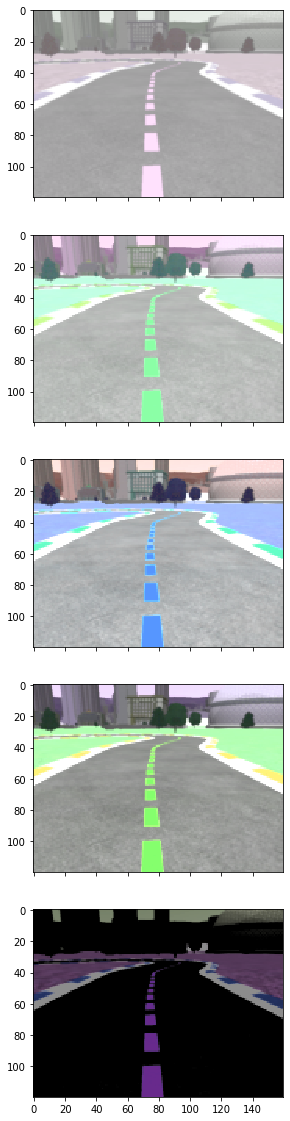

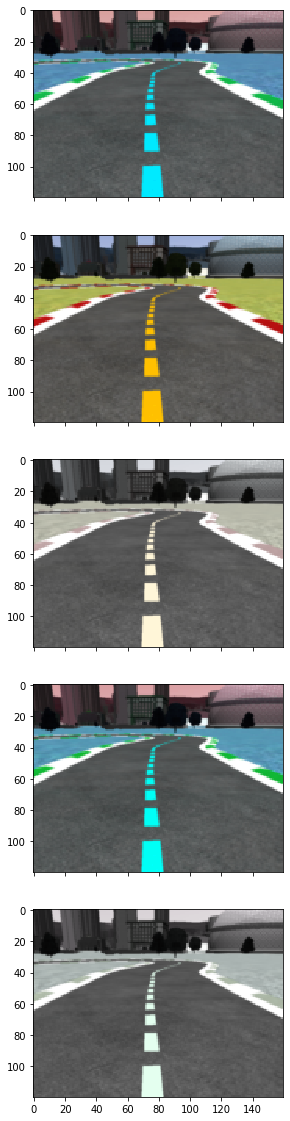

In [331]:
from PIL import ImageEnhance

def perturb_image(image_file, probability):
    image = Image.open(image_file)
    changes = list()
    # contrast: multiplier in RGB space
    if np.random.choice(2, p=(1.0 - probability, probability)):
        changes.append("Contrast")
        contrast_mult = np.random.uniform(0.5,1.5)
        new_contrast_array = np.array(image, 'float') * contrast_mult
        new_contrast_array = np.clip(new_contrast_array, 0, 255)
        image = Image.fromarray(new_contrast_array.astype('uint8'))

    # HSV conversion
    hsv_image = image.convert(mode='HSV')
    h,s,v = hsv_image.split()

    # hue: rotation
    if np.random.choice(2, p=(1.0 - probability, probability)):
        changes.append("Hue")
        # PIL uses 0..255 for Hue range
        hue_delta = np.random.randint(0,255)
        hue_array = np.array(h, dtype='float') # convert to flow to allow overflow
        new_hue_array = (hue_array + hue_delta) % 256
        h = Image.fromarray(new_hue_array.astype('uint8'), 'L')

    # saturation: multiplier
    if np.random.choice(2, p=(1.0 - probability, probability)):
        changes.append("Saturation")
        sat_mult = np.random.uniform(0.0,1.0)
        sat_array = np.array(s, dtype='float')
        new_sat_array = sat_array * sat_mult
        new_sat_array = np.clip(new_sat_array, 0, 255)
        s = Image.fromarray(new_sat_array.astype('uint8'), 'L')

    # brightness: delta
    if np.random.choice(2, p=(1.0 - probability, probability)):
        changes.append("Brightness")
        bright_delta = np.random.randint(-127,127)
        bright_array = np.array(v, dtype='float')
        new_bright_array = bright_array + bright_delta
        new_bright_array = np.clip(new_bright_array, 0, 255)
        v = Image.fromarray(new_bright_array.astype('uint8'), 'L')

    final_image = Image.merge('HSV', (h,s,v))
    final_image = final_image.convert(mode='RGB')
    print('Changes: %s' % ','.join(changes))
    return np.array(final_image)
    
image_file = 'images/canada_training/1680.png'

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 20),
                       sharex=True, sharey=True)
# random perturbations with prob 1.0
ax[0].imshow(perturb_image(image_file, 1.0))
ax[1].imshow(perturb_image(image_file, 1.0))
ax[2].imshow(perturb_image(image_file, 1.0))
ax[3].imshow(perturb_image(image_file, 1.0))
ax[4].imshow(perturb_image(image_file, 1.0))

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 20),
                       sharex=True, sharey=True)
# random perturbations with prob 0.2
ax[0].imshow(perturb_image(image_file, 0.2))
ax[1].imshow(perturb_image(image_file, 0.2))
ax[2].imshow(perturb_image(image_file, 0.2))
ax[3].imshow(perturb_image(image_file, 0.2))
ax[4].imshow(perturb_image(image_file, 0.2))

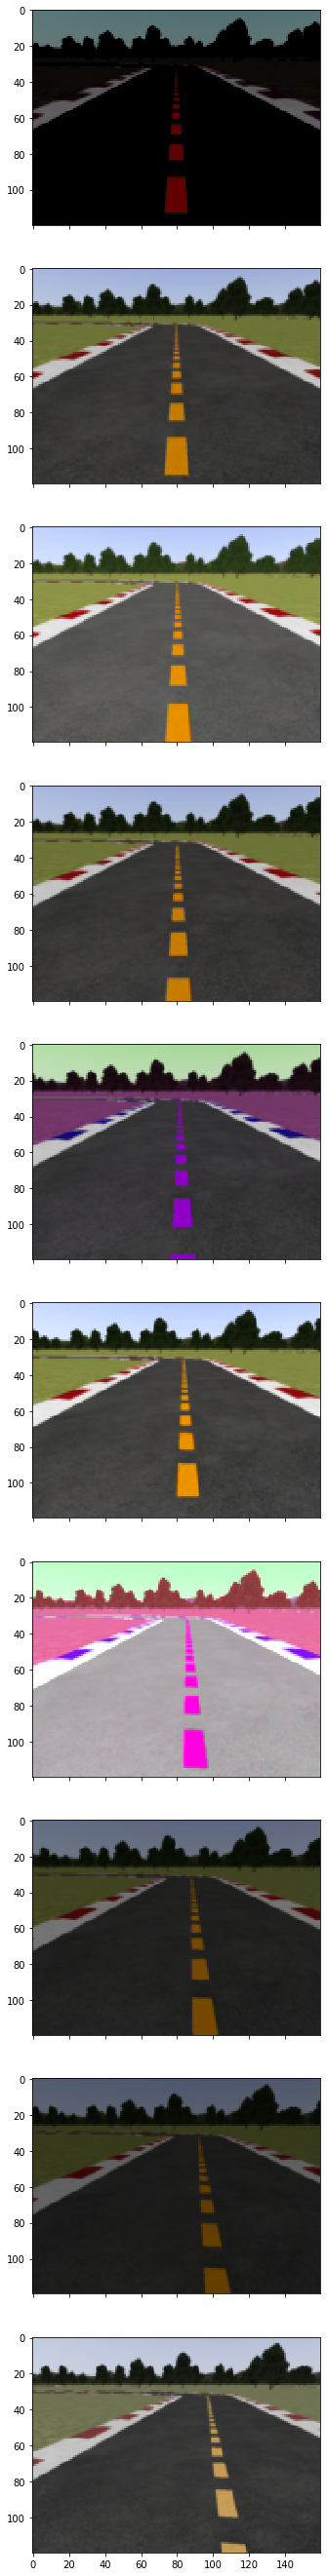

In [333]:
image1 = Image.open('images/perturb/color_perturb_filter_1573533945.847555.png')
image2 = Image.open('images/perturb/color_perturb_filter_1573533946.518242.png')
image3 = Image.open('images/perturb/color_perturb_filter_1573533947.221847.png')
image4 = Image.open('images/perturb/color_perturb_filter_1573533947.884305.png')
image5 = Image.open('images/perturb/color_perturb_filter_1573533948.570559.png')
image6 = Image.open('images/perturb/color_perturb_filter_1573533949.218567.png')
image7 = Image.open('images/perturb/color_perturb_filter_1573533949.871383.png')
image8 = Image.open('images/perturb/color_perturb_filter_1573533950.546981.png')
image9 = Image.open('images/perturb/color_perturb_filter_1573533951.206675.png')
image10 = Image.open('images/perturb/color_perturb_filter_1573533951.866570.png')
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(12, 48),
                       sharex=True, sharey=True)
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image3)
ax[3].imshow(image4)
ax[4].imshow(image5)
ax[5].imshow(image6)
ax[6].imshow(image7)
ax[7].imshow(image8)
ax[8].imshow(image9)
ax[9].imshow(image10)

In [285]:
image = Image.open(image_file)
image_array = np.array(image)

image_tensor = tf.image.resize(image_array, (120,160))
# hue
if np.random.choice((True,False),p=(0.2,0.8)):
    image_tensor = tf.image.random_hue(image_tensor, 0.5)
# saturation
if np.random.choice((True,False), p=(0.2,0.8)):
    image_tensor = tf.image.random_saturation(image_tensor, 0.0, 1.0)
# contrast
if np.random.choice((True,False), p=(0.2,0.8)):
    image_tensor = tf.image.random_contrast(image_tensor, 0.0, 1.0)
# brightness
if np.random.choice((True,False), p=(0.2,0.8)):
    image_tensor = tf.image.random_brightness(image_tensor, 0.5)

plt.imshow(image_tensor.eval(session=model))


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

# RoboMaker Simulation Evaluation

Here we run the real time-consuming evaluations in RoboMaker.
These can be run along with the quick analysis above or only after some threshold achieved.

In [ ]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print ("Created kinesis video stream {}".format(kvs_stream_name))

In [168]:
# Setup specific to my account
simulation_app_arn = 'arn:aws:robomaker:us-east-1:345864641105:simulation-application/deepracer-simapp-051bbb71-b8cb-4898-a31f-979631825e54/1564689218391'
deepracer_subnets = [
    'subnet-0b462e2666bfc8b42',
    'subnet-0c17dcc711ca0d647',
    'subnet-0308c84b560b7523f',
    'subnet-02859793120cd62b1',
    'subnet-0907b942eaf144f31',
    'subnet-0f34973fdfcaac137',
]
deepracer_security_groups = ['sg-0b9bd3a41e11cf278']
account_id = '345864641105'
sagemaker_role = 'arn:aws:iam::345864641105:role/service-role/AWSDeepRacerSageMakerAccessRole'

### Simple evaluation

In [126]:
sys.path.append("./src")

num_simulation_workers = 1
job_duration_in_seconds = 3600

envriron_vars = {
    "WORLD_NAME": "reinvent_base",
    "KINESIS_VIDEO_STREAM_NAME": "SilverstoneStream",
    "MODEL_S3_BUCKET": s3_bucket,
    "MODEL_S3_PREFIX": s3_prefix,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model_metadata.json" % s3_prefix,
    "METRICS_S3_BUCKET": s3_bucket,
    "METRICS_S3_OBJECT_KEY": s3_bucket + "/evaluation_metrics.json",
    "NUMBER_OF_TRIALS": "5",
    "ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID": account_id
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Continue",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

# print("Created the following jobs:")
for response in responses:
    
    print("Job ARN", response["arn"])

NameError: name 'sys' is not defined

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_bucket, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:  
    data = json.load(fp)

df = pd.DataFrame(data['metrics'])
# Converting milliseconds to seconds
df['elapsed_time'] = df['elapsed_time_in_milliseconds']/1000
df = df[['trial', 'completion_percentage', 'elapsed_time']]

display(df)

### Robust Evaluation

In [ ]:
sys.path.append("./src")

num_simulation_workers = 1

envriron_vars = {
    "WORLD_NAME": "reinvent_base",
    "KINESIS_VIDEO_STREAM_NAME": "SilverstoneStream",
    "MODEL_S3_BUCKET": s3_bucket,
    "MODEL_S3_PREFIX": s3_prefix,
    "APP_REGION": aws_region,
    "MODEL_METADATA_FILE_S3_KEY": "%s/model_metadata.json" % s3_prefix,
    "METRICS_S3_BUCKET": s3_bucket,
    "METRICS_S3_OBJECT_KEY": s3_bucket + "/evaluation_metrics.json",
    "NUMBER_OF_TRIALS": "5",
    "ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID": account_id
}

simulation_application = {
    "application":simulation_app_arn,
    "launchConfig": {
         "packageName": "deepracer_simulation_environment",
         "launchFile": "evaluation.launch",
         "environmentVariables": envriron_vars
    }
}
                            
vpcConfig = {"subnets": deepracer_subnets,
             "securityGroups": deepracer_security_groups,
             "assignPublicIp": True}

responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                                outputLocation={ 
                                                  "s3Bucket": s3_bucket,
                                                  "s3Prefix": s3_prefix
                                                },
                                                maxJobDurationInSeconds=job_duration_in_seconds,
                                                iamRole=sagemaker_role,
                                                failureBehavior="Continue",
                                                simulationApplications=[simulation_application],
                                                vpcConfig=vpcConfig)
    responses.append(response)

# print("Created the following jobs:")
for response in responses:
    
    print("Job ARN", response["arn"])